<a href="https://colab.research.google.com/github/HiroshiATakano/QC_Kentei/blob/main/Level1_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de correlación y Análisis de regresión

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

path = os.getcwd()

try:
  os.chdir(path + '/drive/My Drive/QC_Kentei')
except:
  pass

os.getcwd()

'/content/drive/My Drive/QC_Kentei'

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

import gspread

# 認証のためのコード
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

## 14.1

ある製品の強度ｙに影響を与えている要因として、行程中での添加物量ｘが関係しているのではないかと考えられたので、調べたところ表１４．１のデータを得た。

* 分散分析表を作成せよ。

Se considera que la cantidad de aditivos x durante el proceso de producción los datos de la tabla 14.1.

* Elabore una tabla de análisis de varianza


In [ ]:
url = "https://docs.google.com/spreadsheets/d/1Ma7ehT4TAnkUwJjspP-C3mwJA1hYmbJr8B9GJSFI0lU/edit?usp=sharing"
ss = gc.open_by_url(url)

# Obtener los datos (como lista)
st = ss.worksheet("Sheet15")
list_of_lists = st.get_all_values()

df = pd.DataFrame.from_records(list_of_lists)
df.columns = df.iloc[0]
df = df.drop(index=0)

df = df.apply(pd.to_numeric)

print(df)

df.to_excel("Data_1/14_1.xlsx",index=False)

df_long = df.melt(id_vars=['x'], var_name='category', value_name='y')
df_long = df_long[['x','y']]

df_long.to_excel("Data_1/14_1_long.xlsx",index=False)


0   x  y1  y2  y3
1  10  35  33  30
2  15  29  30  28
3  20  27  28  25
4  25  26  25  24


In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

df = df_long.copy()

# Suma total de cuadrados (SST)
y_mean = np.mean(df['y'])
SST = np.sum((df['y'] - y_mean) ** 2)

# Modelo de regresión linear
X_lin = sm.add_constant(df['x'])  # Añadir el intercepto
model_lin = sm.OLS(df['y'], X_lin).fit()
y_pred_lin = model_lin.fittedvalues
SSR_lin = np.sum((y_pred_lin - y_mean) ** 2)  # Suma de cuadrados de la regresión de la regresión lineal
SSE_lin = np.sum((df['y'] - y_pred_lin) ** 2)  # Suma de cuadrados de los residuos de la regresión lineal

# Modelo de regresión de orden superior (de segundo grado)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(df[['x']])
model_poly = sm.OLS(df['y'], X_poly).fit()
y_pred_poly = model_poly.fittedvalues
SSR_poly = np.sum((y_pred_poly - y_mean) ** 2)  # Suma de cuadrados entre grupos
SSE_poly = np.sum((df['y'] - y_pred_poly) ** 2)  # Suma de cuadrados de la regresión de orden superior

# Suma de cuadrados de la regresión de orden superior
SSR_high = SSR_poly - SSR_lin  # Regresión de orden superor
               #  = Suma de cuadrados entre grupos - Suma de cuadrados de la regresión lineal

# Suma de cuadrados de los residuos
SSE = SSE_poly  # Adoptar el error del modelo de regresión de orden superior

# Grados de libertad
df_lin = 1  # Regresión lineal
df_high = 2  # Regresión de orden superior (para el segundo grado)
df_total = len(df['y']) - 1
df_error = df_total - (df_lin + df_high)

# Media de cuadrados
MSR_lin = SSR_lin / df_lin
MSR_high = SSR_high / df_high
MSR_poly = SSR_poly / (df_high + df_lin)
MSE = SSE / df_error

# Valor de F
F_lin = MSR_lin / MSE
F_high = MSR_high / MSE
F_poly = MSR_poly / MSE

# Elaboración de la tabla de análisis de varianza
anova_table = pd.DataFrame({
    'Suma de cuadrados': [SSR_lin, SSR_high, SSR_poly, SSE, SST],
    'Grados de libertad': [df_lin, df_high, df_lin + df_high, df_error, df_total],
    'Media de cuadrados': [MSR_lin, MSR_high, MSR_poly, MSE, None],
    'Valor de F': [F_lin, F_high, F_poly, None, None]
}, index=['Regresión lineal', 'Regresión de orden superior ', 'Entre grupos', 'Error', 'Total'])

anova_table = anova_table.round(2)
anova_table


,Suma de cuadrados,Grados de libertad,Media de cuadrados,Valor de F
Regresión lineal,96.27,1,96.27,35.99
Regresión de orden superior,3.00,2,1.50,0.56
Entre grupos,99.27,3,33.09,12.37
Error,21.40,8,2.68,NaN
Total,120.67,11,NaN,NaN


高次回帰は有意ではなく $ F_0 $ 値も小さいので、誤差にプールして分散分析表を作り直す

La regresión de orden superior no es significativa y el valor de $ F_0 $ es pequeño, por lo que se agrupa en el error y se vuelve a elaborar la tabla de análisis de varianza.

In [ ]:
# Agrupar en el error
sse_pooled = SSE_poly + SSR_high  # Añadir la suma de cuadrados de la regresión de orden
                                  # superior a la suma de cuadrados del error
df_pooled = df_total - df_lin  # Actualizar los grados de libertad del error
mse_pooled = sse_pooled / df_pooled  # Media de cuadrados

# Elaboración de la tabla de análisis de varianza
data_anova = {
    "Suma de cuadrados": [SSR_lin, sse_pooled, ss_total],
    "Grados de libertad": [df_lin, df_pooled, df_total],
    "Media de cuadrados": [SSR_lin / df_lin, mse_pooled, "-"],
    "Valor de F": [SSR_lin / df_lin / mse_pooled, "-", "-"]
}

anova_df = pd.DataFrame(data_anova, index=["Regresión lineal", "Error (después de agrupar)", "Total"])
anova_df = anova_df.map(lambda x: '{:.2f}'.format(x) if isinstance(x, (float)) else x )
anova_df

,Suma de cuadrados,Grados de libertad,Media de cuadrados,Valor de F
Regresión lineal,96.27,1,96.27,39.45
Error (después de agrupar),24.40,10,2.44,-
Total,120.67,11,-,-


回帰直線を当てはめる。

Ajustar la recta de regresión


Ecuación de regresión: y = 37.2 + -0.5 * x


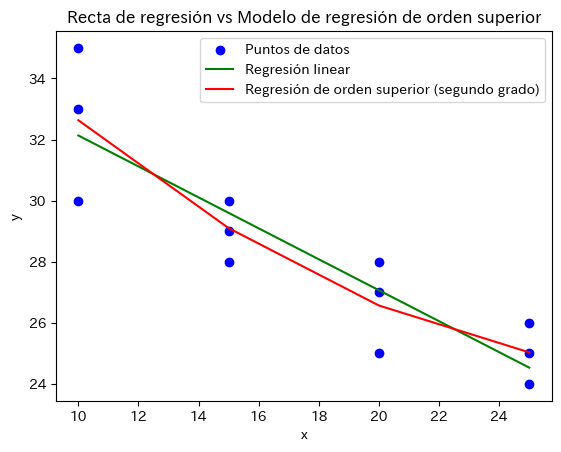

In [ ]:
# Obtener los coeficientes de la ecuación de regresión
b0, b1 = model_lin.params

# Mostrar la ecuación de regresión
print(f"Ecuación de regresión: y = {b0:.1f} + {b1:.1f} * x")

# Recta de regresión
plt.scatter(X, y, color='blue', label='Puntos de datos')
plt.plot(X, y_linear_pred, color='green', label='Regresión linear')
plt.plot(X, y_poly_pred, color='red', label='Regresión de orden superior (segundo grado)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Recta de regresión vs Modelo de regresión de orden superior')
plt.show()